## Evolent Health:

####Dependencies:

In [1]:
import numpy as np
import pandas as pd
import gensim
from keras.preprocessing import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
%matplotlib inline
from sklearn.model_selection import train_test_split

import re
from bs4 import BeautifulSoup

import nltk


#### Data:

In [2]:
df=pd.read_csv("/content/drive/MyDrive/BeerDataScienceProject.csv", encoding="ISO-8859-1")
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [3]:
#helper function to view the table content details
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=52):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [4]:
tbl_report(df)

Table Shape (528870, 13)


,dtype,nulls,uniques,num_uniques,value_counts
beer_ABV,float64,20280,"[5.0, 6.2, 6.5, 7.7, 4.7, 7.2, 5.6, 7.4, 5.5, 5.8, 8.1, nan, 8.8, 5.7, 7.0, 6.3, 3.9, 6.7, 6.1, 9.5, 5.2, 6.8, 7.6, 5.4, 8.5, 4.5, 4.2, 4.0, 9.0, 8.0, 4.1, 10.4, 5.1, 10.0, 7.1, 4.6, 4.8, 7.5, 0.1, 3.5, 3.8, 4.4, 2.2, 4.9, 2.8, 6.0, 5.3, 8.4, 10.5, 9.8, 5.9, 12.0, 4.3, 4.19, 8.6, 5.79, 10.9, 9.3, 8.85, 8.3, 8.7, 6.6, 7.25, 3.75, 3.1, 5.25, 4.37, 11.1, 6.4, 11.0, 0.5, 8.2, 11.3, 7.8, 6.9, 9.4, 13.0, 4.75, 5.75, 9.2, 1.5, 3.0, 3.7, 7.9, 9.9, 8.9, 7.3, 2.5, 14.0, 15.0, 11.5, 7.82, 16.0, 10.25, 10.1, 3.2, 3.4, 3.6, 30.86, 57.7, ...]",284,NA
beer_beerId,int64,0,"[47986, 48213, 48215, 47969, 64883, 52159, 10789, 12386, 58046, 25414, 10788, 58920, 21241, 20818, 10786, 10794, 54330, 20817, 61427, 10784, 76963, 23290, 54723, 3274, 60951, 37917, 56071, 42964, 10793, 10785, 72330, 60990, 54216, 39314, 45855, 45543, 45628, 55951, 8769, 64800, 68668, 68672, 69087, 64803, 15894, 44082, 39606, 41584, 12835, 51834, 41084, 8770, 37498, 70395, 49803, 30090, 30084, 30088, 27689, 30089, 30085, 1415, 66308, 1419, 59239, 436, 3386, 33584, 1417, 1414, 1413, 1418, 23326, 23329, 23328, 23327, 40395, 40394, 27666, 26817, 26133, 27664, 26419, 26418, 26420, 27799, 26132, 52445, 36470, 22808, 3825, 36580, 22604, 38540, 23315, 36609, 36484, 36720, 22615, 42953, ...]",20200,NA
beer_brewerId,int64,0,"[10325, 1075, 8802, 2724, 7345, 12770, 163, 3407, 16604, 11715, 18185, 1463, 1454, 850, 15524, 577, 14756, 14589, 24162, 21841, 13614, 26612, 25484, 13956, 26983, 17293, 26990, 24517, 5330, 10912, 21138, 19380, 3087, 16859, 23246, 421, 7314, 18847, 23082, 2188, 15527, 20658, 10103, 15607, 15636, 1746, 3631, 5476, 2055, 16994, 971, 25966, 25953, 10774, 9300, 14879, 20988, 2310, 17204, 1303, 25684, 936, 2446, 1487, 5007, 12907, 21516, 3282, 23022, 3207, 4078, 12003, 6277, 1917, 22288, 16791, 16863, 22167, 23739, 1386, 2430, 24072, 9345, 1482, 5752, 765, 26946, 10950, 395, 3965, 26816, 23020, 2647, 13670, 21590, 5049, 2464, 365, 16050, 14365, ...]",1803,NA
beer_name,object,0,"[Sausa Weizen, Red Moon, Black Horse Black Beer, Sausa Pils, Cauldron DIPA, Caldera Ginger Beer, Caldera Oatmeal Stout, Caldera OBF 15, Rauch Ür Bock, Caldera Pale Ale, Pilot Rock Porter, Vas Deferens Ale, Cauldron Espresso Stout, Old Growth Imperial Stout, Dry Hop Red, Southside Strong, Caldera Märzen, Lawnmower Lager, Caldera Rose Petal (Kettle Series), Caldera IPA, Coconut Porter, Dry Hop Orange, Alpha Beta, Caldera Pilsener Bier, Hibiscus Ginger Beer, Exotic Erotic Passion Fruit Ale, Hopportunity Knocks, Imperial Stout, Cauldron Brew, Ashland Amber, Hop Hash, Mogli, Welsh Honey Bitter, Telford Porter, Celebration Ale, Welsh Pride, Honey Fayre, Holiday Imperial, Columbus India Pale Ale, Holiday XXII Imperial Blue, Luck O' The Irish, Old Oakland Ale, Yellowjacket Ale, Megalodon, Code Blue, Orca Porter, Leviathan Imperial Stout, Holiday Trappist Style Ale, Deviator Doppelbock, Blue Whale Ale, Grey Whale Ale, Killer Whale Stout, Emerald Ale, Schinderhannes Bock, Kirner Pils Premium, City Razz, City Light, City Pale Ale, City Stout, City Pumpkin, City Amber, Amstel Gold, Amstel Sterk (Strong), Amstel Oud Bruin, Amstel Malt, Amstel Light, Amstel Bright, Amstel (Pure Filtered), Amstel Lentebock, Amstel Lager, Amstel 1870, Amstel Bock, Amber IPA, Original Lager, Red Alt Ale, Gosch, Kollers Naturtrüb Dunkel, Kollers Naturtrüb Hell, Holiday Ale, Pumpkin Ale, Dry Stout, Newark IPA, Red Rye Ale, Wheat Ale, Pale Ale, Sweet Stout, IPA, Nobu Special Reserve, Harboe Silver Beer 3,5%, Harboe Den Glada Danskens Lättöl, Harboe Bjørnebryg (Bear Beer), Harboe Pilsner 2,8%, Harboe Bjørnebryg Extra Stark (Bear Beer Extra Strong), Harboe Kräftöl, Netto ""24"" Fødselsdags-Bryg, Harboe Påskebryg 2,8%, Harbroe Classic Beer 2,8%, Harboe Pilsner 3,5%, Harboe Classic 110, Skælskør Original Black, ...]",18339,NA
beer_style,object,0,"[Hefeweizen, English Strong Ale, Foreign / Export Stout, German Pilsener, American Double / Imperial IPA, Herbed / Spice

#### Visualisation:

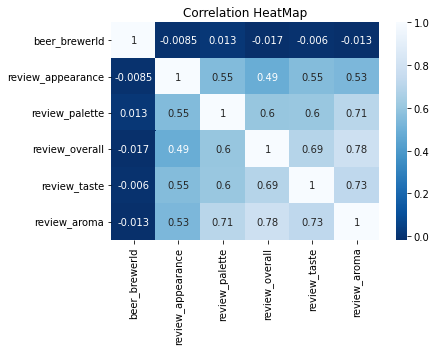

In [6]:
#checking correlations between the relevant attributes
sns.heatmap(df[df.columns[2:-2]].corr(),annot=True,cmap='Blues_r')
plt.title("Correlation HeatMap")
plt.savefig("./heatmap")

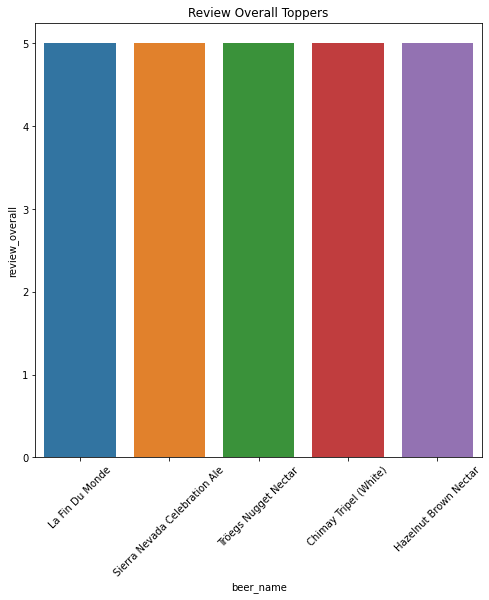

In [7]:
fig,axes=plt.subplots(figsize=(8,8))
df_vis=df[(df.review_overall>=4)&(df.review_taste>=4)&(df.review_aroma>=4)&(df.review_palette>=4)&(df.review_appearance>=4)].sort_values(by='review_overall',ascending=False)[:20]
sns.barplot(data=df_vis,x="beer_name",y="review_overall",ax=axes)
plt.xticks(rotation="45")
plt.title("Review Overall Toppers")
plt.savefig("./review_overall")

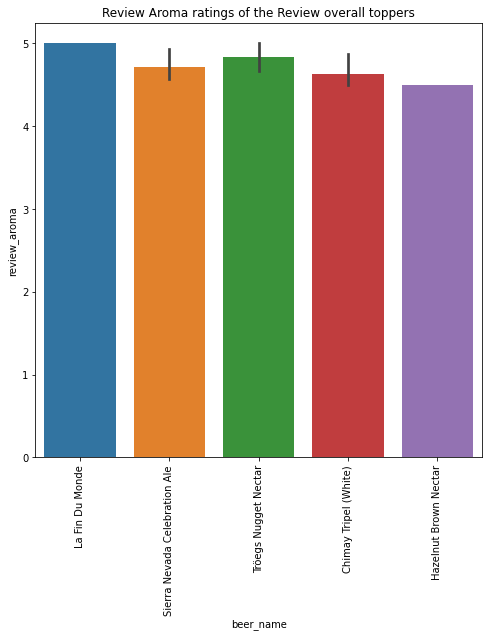

In [8]:
fig,axes=plt.subplots(figsize=(8,8))
sns.barplot(data=df_vis,x="beer_name",y="review_aroma",ax=axes)
plt.xticks(rotation="90")
plt.title("Review Aroma ratings of the Review overall toppers")
plt.savefig("./Review_Aroma")

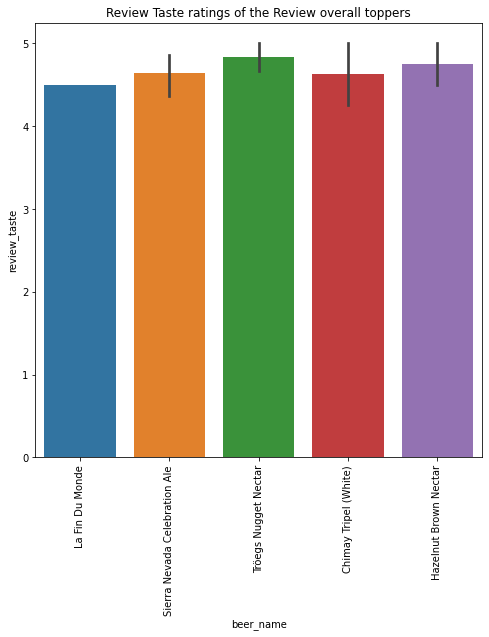

In [9]:
fig,axes=plt.subplots(figsize=(8,8))
sns.barplot(data=df_vis,x="beer_name",y="review_taste",ax=axes)
plt.xticks(rotation="90")
plt.title("Review Taste ratings of the Review overall toppers")
plt.savefig("./Review_Taste")

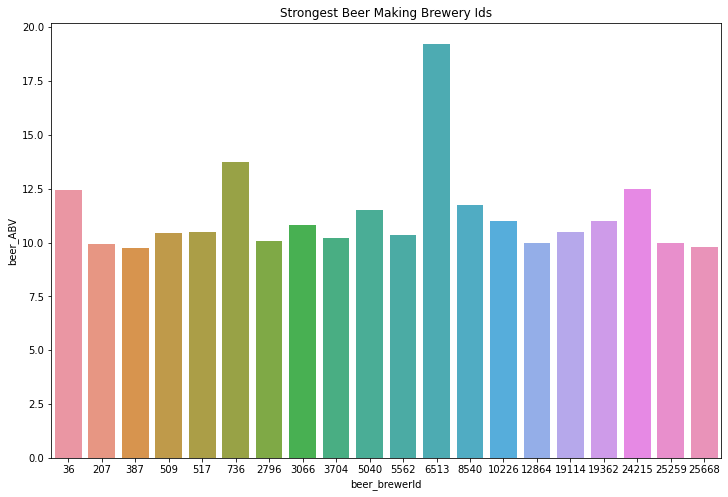

In [10]:
df_brewer=df.groupby(by="beer_brewerId")['beer_ABV'].mean().sort_values(ascending=False)[:20]
fig,axes=plt.subplots(figsize=(12,8))
sns.barplot(x=df_brewer.index,y=df_brewer,ax=axes)
plt.title("Strongest Beer Making Brewery Ids")
plt.savefig("./StrongBeer")

In [11]:
import datetime
for i in df_vis['review_time']:
 print( datetime.datetime.fromtimestamp(i).isoformat())

2008-02-05T00:16:49
2008-01-22T03:17:29
2006-02-09T15:55:21
2010-12-26T08:46:23
2008-01-03T21:23:02
2010-12-18T03:17:26
2008-01-08T20:50:20
2008-01-09T01:32:41
2008-01-10T16:48:48
2008-01-10T17:16:59
2006-02-12T01:28:18
2006-02-12T02:32:22
2006-02-14T02:25:54
2006-02-16T02:04:17
2005-01-22T19:37:31
2005-01-21T01:03:39
2008-01-22T13:54:37
2006-02-20T23:41:52
2010-11-14T22:41:26
2010-11-13T17:26:41


### Textual EDA

In [26]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

In [27]:
temp = df.dropna().groupby('review_overall').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')
fig = go.Figure(go.Funnelarea(
    text =temp.review_overall,
    values = temp.review_text,
    title = {"position": "top center", "text": "Funnel-Chart of Rating Distribution"}
    ))
fig.show()
plt.savefig("Funnel")

<Figure size 432x288 with 0 Axes>

### Review Classification

In [48]:
text=df.dropna()
text

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528792,5.1,29915,3340,Dinkelacker Goldhälsle,German Pilsener,4.0,3.5,4.5,4.0,Lexluthor33,4.0,MSG-watching the Knicks lose. (Notes) Clear ye...,1228362569
528793,5.1,29915,3340,Dinkelacker Goldhälsle,German Pilsener,4.0,3.5,3.5,3.5,stoutman,3.5,"Clean clear yellow body, with a full white foa...",1145135174
528794,4.9,32658,3340,Schwaben Pilsner,German Pilsener,3.5,3.5,3.0,3.0,thierrynantes,3.0,"Beer bottle (33cl.), tasted in 2002. Appearanc...",1228640743
528795,4.9,32658,3340,Schwaben Pilsner,German Pilsener,3.0,3.0,3.5,3.0,wl0307,3.0,"Like the previous reviewer, I got this beer at...",1166818317


In [49]:
text.groupby('beer_style').count()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
beer_style,,,,,,,,,,,,
Altbier,3538,3538,3538,3538,3538,3538,3538,3538,3538,3538,3538,3538
American Adjunct Lager,9033,9033,9033,9033,9033,9033,9033,9033,9033,9033,9033,9033
American Amber / Red Ale,17602,17602,17602,17602,17602,17602,17602,17602,17602,17602,17602,17602
American Amber / Red Lager,2793,2793,2793,2793,2793,2793,2793,2793,2793,2793,2793,2793
American Barleywine,9984,9984,9984,9984,9984,9984,9984,9984,9984,9984,9984,9984
...,...,...,...,...,...,...,...,...,...,...,...,...
Vienna Lager,4298,4298,4298,4298,4298,4298,4298,4298,4298,4298,4298,4298
Weizenbock,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182
Wheatwine,882,882,882,882,882,882,882,882,882,882,882,882


In [50]:
#text=pd.DataFrame()
#for i in df['beer_style'].unique():
  #text=pd.concat([text,df[df.beer_style==i].dropna()[:891]])

In [51]:
text.reset_index(inplace=True)

In [52]:
# function to perform stemming

def stemming(text):
    
    # stems each word in the review to it's root word
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [53]:
def preprocess_review(text):
    
    """
    Function
    --------
    preprocess_review

    Inputs
    ------
    text: the review which need to be pre-processed

    Returns
    -------
    clean_review: the pre-processed review obtained 
    """
    
    
    clean_review = BeautifulSoup(text).get_text()
    clean_review = clean_review.lower()
    clean_review =re.sub(('[^a-z\s]+')," ",clean_review)
    clean_review =re.sub(('\s+')," ",clean_review)
    stemming_review = stemming(clean_review)
    #print(stemming_review)
    return stemming_review

In [54]:
X = [preprocess_review(review) for review in text['review_text']]
print('data cleaned')

data cleaned


In [55]:
#Tokenization
tokenizer = CountVectorizer(max_features = 1000, stop_words = 'english')

In [56]:
# tokenizing the words in X
tokenizer.fit(X)
X_train_tokenized = tokenizer.transform(X)
tokenized_sum = X_train_tokenized.sum(axis = 0)

count_list = []
for word,index in tokenizer.vocabulary_.items():
    count_list.append((word,tokenized_sum[0,index]))

sorted_countlist = sorted(count_list,key= lambda x: x[1],reverse= True)

In [81]:
y_train=[1 if y>=3 else 0 for y in text.review_overall]

In [82]:
#logistic regression to have a look at approximate positive and negative reviews
c=[0.001,0.01,0.1,1,10,100]
error=np.empty(6)
max=0
index=0
for i in range(6):
 logr=LogisticRegression(C=c[i])
 model=logr.fit(X_train_tokenized,y_train)
 predict_ontest=model.predict(X_train_tokenized)
 if (accuracy_score(y_train,model.predict(X_train_tokenized))>max):
    bow_model=model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

In [83]:
print("training_set", accuracy_score(y_train,bow_model.predict(X_train_tokenized)))

training_set 0.9379138323779699


In [84]:
# function to plot confusion matrix

def plot_confusion_matrix(model, validation_features, validation_labels):
     
    """
    Function
    --------
    plot_confusion_matrix

    Inputs
    ------
    model: the classification model
    validation_features: features/variables used in the model (X)
    validation_labels: response variable (good/bad sentiment) (y)

    Notes
    -----
    Calling this function should plot a confusion matrix. 
    """
    
    # Predict the values from the validation dataset
    y_pred = model.predict(validation_features)
    
    # Convert validation observations to one hot vectors
    y_true = [1 if y>0.5 else 0 for y in y_pred]
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(validation_labels,y_true)

    df_cm = pd.DataFrame(confusion_mtx, range(2),
                      range(2))
    sns.heatmap(df_cm, annot=True, annot_kws = {'size':15}, cmap = 'Blues',fmt = 'd',
                norm=matplotlib.colors.LogNorm(df_cm.values.min(),df_cm.values.max()),
                cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4]},vmin=0.001, vmax=10000)
    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim(2,0)
    plt.savefig("./confusion")
    plt.show()
    

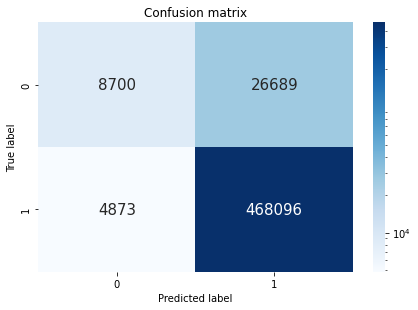

In [85]:
plot_confusion_matrix(bow_model, X_train_tokenized, y_train)

In [89]:
from sklearn.ensemble import RandomForestClassifier
rg=RandomForestClassifier(random_state=41,max_depth=7,min_samples_leaf=2,n_estimators=800,oob_score=True)
rg.fit(X_train_tokenized,y_train)
print("training_set", accuracy_score(y_train,rg.predict(X_train_tokenized)))


training_set 0.9303856730886502


###Analysis of Results:

In [45]:
df.groupby('beer_style').mean()['review_overall'].sort_values(ascending=False)

beer_style
Gueuze                              4.140952
Berliner Weissbier                  4.133976
American Double / Imperial Stout    4.100518
Oatmeal Stout                       4.080768
Eisbock                             4.079487
                                      ...   
Light Lager                         2.913462
Happoshu                            2.818182
Euro Strong Lager                   2.817995
American Malt Liquor                2.722183
Low Alcohol Beer                    2.602740
Name: review_overall, Length: 104, dtype: float64

In [86]:
text['review_class']=bow_model.predict(X_train_tokenized)

In [87]:
text

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,review_class
0,0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823,1
1,1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097,1
2,2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,1
3,3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,1
4,4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508353,528792,5.1,29915,3340,Dinkelacker Goldhälsle,German Pilsener,4.0,3.5,4.5,4.0,Lexluthor33,4.0,MSG-watching the Knicks lose. (Notes) Clear ye...,1228362569,1
508354,528793,5.1,29915,3340,Dinkelacker Goldhälsle,German Pilsener,4.0,3.5,3.5,3.5,stoutman,3.5,"Clean clear yellow body, with a full white foa...",1145135174,1
508355,528794,4.9,32658,3340,Schwaben Pilsner,German Pilsener,3.5,3.5,3.0,3.0,thierrynantes,3.0,"Beer bottle (33cl.), tasted in 2002. Appearanc...",1228640743,1
508356,528795,4.9,32658,3340,Schwaben Pilsner,German Pilsener,3.0,3.0,3.5,3.0,wl0307,3.0,"Like the previous reviewer, I got this beer at...",1166818317,1


In [88]:
text.groupby('beer_style').mean()['review_class'].sort_values(ascending=False)

beer_style
Roggenbier              1.000000
Rye Beer                0.995417
American Black Ale      0.995251
Eisbock                 0.994845
Oatmeal Stout           0.993727
                          ...   
Euro Strong Lager       0.782849
Happoshu                0.745455
Light Lager             0.736324
American Malt Liquor    0.694940
Low Alcohol Beer        0.634483
Name: review_class, Length: 104, dtype: float64

In [76]:
text[(text.beer_style=='Oatmeal Stout')&(text.review_class==1)]['review_text'].count()

5634

In [78]:
text[(text.beer_style=='Rye Beer')&(text.review_class==0)]['review_text'].count()


621

In [80]:
text[(text.beer_style=='Low Alcohol Beer')&(text.review_class==1)]['review_text'].count()


14

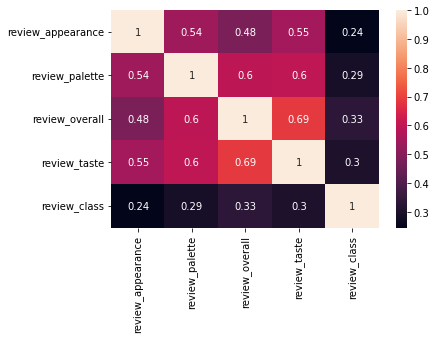

In [94]:
sns.heatmap(data=text[text.columns[[6,7,8,9,14]]].corr(),annot=True)

In [100]:
text[(text.beer_style=='Roggenbier')&(text.review_class==1)]['review_text']

54610     Aparently both top and bottom fermented. A: Al...
99592     Sampled 4/29/2011 at the brewery. Pours hazy d...
161957    Served in a pint glass at the brewery. A: Murk...
161958    On tap at the brewery. A: Cloudy tannish color...
161959    Served out of a pitcher at the brewpub in Heal...
                                ...                        
490874    500ml bottle. Pours dark chestnut brown with a...
490875    On tap at Churchkey yesterday. Served in a min...
490876    First off this is no Belgian-style farmhouse/s...
490877    As I'm part Finnish, I'm always interested to ...
490878    Be aware. This is not your "typical" Farmhouse...
Name: review_text, Length: 140, dtype: object

In [102]:
text.iloc[490878]['review_text']

'Be aware. This is not your "typical" Farmhouse Ale, despite the label indicating "Modern Scandinavian Farmhouse Ale." This one is "very modern," indeed. This is a huge beer with none of the character, in my opinion, you would expect in a Farmhouse Ale. That being said, huge rye, dark, flavorful brew. The appearance of this beer is extraordinary. Appears black with an initial thick khaki head. Holding to the light it\'s a clear cranberry copper - very dark and really lovely with the thick head (that unfortunately fades rather quickly. Nose is somewhat average/better than average with medium assertive esters, that "fruity, banana, carnuba wax" smell. Hints of sweet plum and hints of roasted grain and coffee. Mouthfeel is thin but the flavors are so assertive and bold some may not care. In fact, if the mouthfeel was thicker this one might not even be drinkable that\'s how full and bold are the flavors. Taste is just plain big! The bottle label says "Modern Scandinavian Farmhouse Ale." Wo

In [104]:
text[(text.beer_style=='Roggenbier')&(text.review_class==1)]['review_profileName']

54610       sfprint
99592        t0rin0
161957    scottfrie
161958    avaldivia
161959       Norica
            ...    
490874     gford217
490875    Thorpe429
490876       oberon
490877     jlindros
490878      GRG1313
Name: review_profileName, Length: 140, dtype: object